In [ ]:
import requests
requests.get('http://www.google.com',timeout=10).ok

True

In [ ]:
%%capture
!pip install --upgrade kaggle-environments

In [ ]:
%%capture
from kaggle_environments import make
env = make("chess", debug=True)

In [ ]:
%%capture
!pip install python-chess


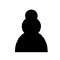
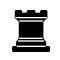
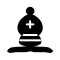
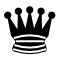
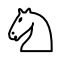
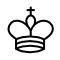
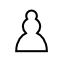
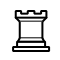
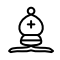
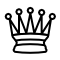
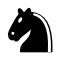
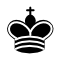

In [ ]:
result = env.run(["random", "random"])
env.render(mode="ipython", width=500, height=500)

In [ ]:
%%writefile main.py
import chess
import random
from random import sample
import time
import psutil
import os

piece_sym = ['K', 'k', 'Q', 'q', 'R', 'r', 'B', 'b', 'N', 'n', 'P', 'p']
piece_val = [0, 0, 9, 9, 5, 5, 3, 3, 3, 3, 1, 1]
piece_val_dict = dict(zip(piece_sym, piece_val))
pawn_table = [
    0, 0, 0, 0, 0, 0, 0, 0,
    5, 5, 5, 5, 5, 5, 5, 5,
    1, 1, 2, 3, 3, 2, 1, 1,
    0.5, 0.5, 1, 2.5, 2.5, 1, 0.5, 0.5,
    0, 0, 0, 2, 2, 0, 0, 0,
    0.5, -0.5, -1, 0, 0, -1, -0.5, 0.5,
    0.5, 1, 1, -2, -2, 1, 1, 0.5,
    0, 0, 0, 0, 0, 0, 0, 0
]



def evaluate_position(board):

  # check for passed pawns
  def is_passed_pawn(board, square, color, cache=None, endgame=False):
    row, col = divmod(square, 8)
    if cache is not None:
        opponent_pawns = cache[chess.BLACK if color == chess.WHITE else chess.WHITE]
    else:
        opponent_pawns = {
            i for i in range(64)
            if board.piece_at(i) and board.piece_at(i).piece_type == chess.PAWN and board.piece_at(i).color != color
        }
    #check if pawn is blocking
    if color == chess.WHITE:
        for i in range(row + 1, 8):
            for offset in [-1, 0, 1]:#for adjacent files
                target = (i * 8) + col + offset
                if target in opponent_pawns:
                    return False
        return True
    else:
        for i in range(row - 1, -1, -1):
            for offset in [-1, 0, 1]:
                target = (i * 8) + col + offset
                if target in opponent_pawns:
                    return False
        return True

  #precomputed sets of pawn positions
  cache = {
        chess.WHITE: {i for i in range(64) if board.piece_at(i) and board.piece_at(i).piece_type == chess.PAWN and board.piece_at(i).color == chess.WHITE},
        chess.BLACK: {i for i in range(64) if board.piece_at(i) and board.piece_at(i).piece_type == chess.PAWN and board.piece_at(i).color == chess.BLACK},
        }

  total_score=0

  #calc score for each peice on board
  for square in range(64):
    piece=board.piece_at(square)
    if piece and piece.piece_type!=chess.PAWN:
      piece_value=piece_val_dict.get(piece.symbol().upper(),0)
      if piece.color==chess.WHITE:
        total_score+=piece_value
      else:
        total_score-=piece_value

  #calc score for pawns acc to pawn table
  for square in range(64):
    piece=board.piece_at(square)
    if piece and piece.piece_type==chess.PAWN:
      row,col=divmod(square,8);
      if piece.color==chess.WHITE:
        total_score+=pawn_table[8 * row + col]
      else:
        total_score-=pawn_table[8 * (7-row) + col]

  #check how far the king is from the center
  king_square=board.king(chess.WHITE)
  if king_square:
    row,col=divmod(king_square,8)
    total_score-=(abs(row-3.5)-abs(col-3.5))*0.5

  king_square=board.king(chess.BLACK)
  if king_square:
    row,col=divmod(king_square,8)
    total_score+=(abs(row-3.5)-abs(col-3.5))*0.5


  #checks if no pawns in diagonals for queen
  for square in range(64):
    piece=board.piece_at(square)
    if piece:
      if piece.piece_type == chess.ROOK:
        reward = 0.5
      else:
        reward = 2
      if piece.piece_type==chess.QUEEN:
        diagonal_pawns = []
        # Up-right diagonal
        for i in range(square + 9, 64, 9):
          if i % 8 == 0:  # Stop if we wrap to the next row
            break
          diagonal_pawns.append(board.piece_at(i))
        # Up-left diagonal
        for i in range(square + 7, 64, 7):
          if i % 8 == 7:  # Stop if we wrap to the previous row
            break
          diagonal_pawns.append(board.piece_at(i))
        # Down-right diagonal
        for i in range(square - 7, -1, -7):
          if i % 8 == 0:  # Stop if we wrap to the next row
            break
          diagonal_pawns.append(board.piece_at(i))
        # Down-left diagonal
        for i in range(square - 9, -1, -9):
          if i % 8 == 7:  # Stop if we wrap to the previous row
            break
          diagonal_pawns.append(board.piece_at(i))
        if all(p is None or p.piece_type!=chess.PAWN for p in diagonal_pawns):
          if piece.color==chess.WHITE:
            total_score+=reward
          else:
            total_score-=reward


    #checks if no pawns in the same file for rook and queen
      if piece.piece_type==chess.ROOK or piece.piece_type==chess.QUEEN:
        file_pawns=[board.piece_at(i) for i in range(square % 8,64,8)]
        if all(p is None or p.piece_type!=chess.PAWN for p in file_pawns):
          if piece.color==chess.WHITE:
            total_score+=reward
          else:
            total_score-=reward

  #reward system for passed pawn
  num_pieces = len([i for i in range(64) if board.piece_at(i)])
  endgame = num_pieces <= 12
  for square in range(64):
    piece = board.piece_at(square)
    if piece and piece.piece_type == chess.PAWN:
      rank = (square // 8) if piece.color == chess.WHITE else (7 - (square // 8))
      if is_passed_pawn(board, square, piece.color, cache, endgame):
        bonus = rank * (1.5 if endgame else 1.0)
        if piece.color == chess.WHITE:
          total_score += bonus
        else:
          total_score -= bonus

  developed_squares = {
    chess.parse_square('b1'),
    chess.parse_square('g1'),
    chess.parse_square('b8'),
    chess.parse_square('g8')
}
  for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.piece_type in {chess.KNIGHT, chess.BISHOP}:
            if square not in developed_squares:  # Original positions
                total_score += 1

  pawns = board.pieces(chess.PAWN, chess.WHITE) | board.pieces(chess.PAWN, chess.BLACK)
  for pawn in pawns:
    if board.is_attacked_by(chess.WHITE, pawn) or board.is_attacked_by(chess.BLACK, pawn):
      total_score += 0.5

  return total_score

def minimax(board, depth, maximizing_player, alpha=float('-inf'), beta=float('inf'), start_time=None, time_limit=None):
    if board.is_checkmate():
        return (float('-inf'), None) if maximizing_player else (float('inf'), None)
    elif board.is_stalemate() or board.is_insufficient_material():
        return 0, None
    elif depth == 0:
        return evaluate_position(board), None
    elif start_time and time_limit and (time.time() - start_time) > time_limit:
        return evaluate_position(board), None

    legal_moves = list(board.legal_moves)
    moves = random.sample(legal_moves, min(len(legal_moves), 10))

    best_move = None
    if maximizing_player:
        max_eval = float('-inf')
        for move in moves:
            board.push(move)  # Make the move
            eval_score, _ = minimax(board, depth - 1, False, alpha, beta, start_time, time_limit)
            board.pop()  # Undo the move
            if eval_score > max_eval:
                max_eval = eval_score
                best_move = move
            alpha = max(alpha, eval_score)
            if beta <= alpha:
                break  # Beta cut-off
        return max_eval, best_move
    else:
        min_eval = float('inf')
        for move in moves:
            board.push(move)  # Make the move
            eval_score, _ = minimax(board, depth - 1, True, alpha, beta, start_time, time_limit)
            board.pop()  # Undo the move
            if eval_score < min_eval:
                min_eval = eval_score
                best_move = move
            beta = min(beta, eval_score)
            if beta <= alpha:
                break  # Alpha cut-off
        return min_eval, best_move


default_fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'

def chess_bot(obs):
  # Set start time and time limit
  start_time = time.time()
  time_limit = 0.15

  # Create a chess.Board object from the FEN string
  board = chess.Board(obs["board"])


  # Get all legal moves
  legal_moves = list(board.legal_moves)
  if not legal_moves:
    return None


    # 1. Try to detect checkmate
  num_pieces = len([i for i in range(64) if board.piece_at(i) and board.piece_at(i).color == chess.BLACK])
  endgame = num_pieces <= 12
  if endgame:
    for move in legal_moves:
      board.push(move)
      if board.is_checkmate():
        board.pop()
        return move.uci()
      board.pop()

    # 2. Check for captures of higher value piece using a lower value piece(implement this in evaluate_position func)
  piece_values = {chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3, chess.ROOK: 5, chess.QUEEN: 9, chess.KING: 0}
  best_capture = None
  highest_value_difference = 0

  for move in legal_moves:
    if board.is_capture(move):
      moving_piece = board.piece_at(move.from_square)
      captured_piece = board.piece_at(move.to_square)
      if captured_piece and moving_piece:
        moving_piece_value = piece_values[moving_piece.piece_type]
        captured_piece_value = piece_values[captured_piece.piece_type]
        value_difference = captured_piece_value - moving_piece_value
        if value_difference > highest_value_difference:
          best_capture = move
          highest_value_difference = value_difference

# 4. Use minimax algorithm with depth=1 to find the best move
  best_move = None
  best_eval = float('-inf')
  for move in legal_moves:
    # Check memory usage
    elapsed_time = time.time() - start_time
    if elapsed_time > time_limit:
      break

    board.push(move)
    eval_score = evaluate_position(board)
    board.pop()

    if eval_score > best_eval:
        best_eval = eval_score
        best_move = move

# Return the best move if found
  if best_move:
    return best_move.uci()
  elif best_capture:
    return best_capture.uci()
  else:
    for move in legal_moves:
      if board.is_capture(move):
        return move.uci()

  return random.choice(legal_moves).uci()

process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 * 1024)
print("Memory Usage:", memory_usage, "MB")



Writing main.py


In [ ]:
import chess

In [ ]:
fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"

board = chess.Board(fen)
legal_moves = list(board.legal_moves)  # This is a generator, so convert to a list
uci_moves = [move.uci() for move in legal_moves]
print("Legal Moves:", uci_moves)

Legal Moves: ['g1h3', 'g1f3', 'b1c3', 'b1a3', 'h2h3', 'g2g3', 'f2f3', 'e2e3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'e2e4', 'd2d4', 'c2c4', 'b2b4', 'a2a4']


Memory Usage: 1081.7734375 MB

Agent exit status/reward/time left: 
	 DONE / 0.5 / 10


	 DONE / 0.5 / 10





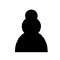
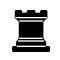
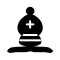
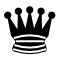
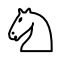
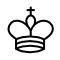
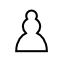
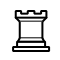
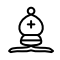
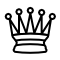
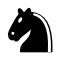
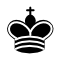

In [ ]:
result = env.run(["main.py", "random"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
  print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
  print("\n")
# render the game
env.render(mode="ipython", width=500, height=500)
